In [1]:
from keras.models import load_model
from ml.models.layers import MyTransformerBlock, MyAddPositionEmbs, MyClassToken
import os
import datetime
from pathlib import Path

import vit_keras.layers

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from PIL import Image
from keras.callbacks import TensorBoard
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.optimizers import Adam

from cfg import LOG_DIR
from ml.models.MySimpleCNN_Feit import MySimpleCNNInceptionModule

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

from ml.pipeline import FeitDataPipelineEncoderDecoder
import numpy as np
import tensorflow
from tensorflow import keras
from ml.util import NeighborhoodImageDataGenerator

tensorflow.compat.v1.disable_eager_execution()

from keras_preprocessing.image import ImageDataGenerator

name = 'MySimpleCNN_FeatureVector_ViT'

class MyAutoencoder(FeitDataPipelineEncoderDecoder):

    @staticmethod
    def _divide(img_np):
        return img_np / 255.0

    def _train_model(self, data_train, data_valid):
        raise NotImplementedError("This method is intentionally not implemented in this instance")

    def get_data_loader_training_autoencoder(self):

        datagen_train = ImageDataGenerator(horizontal_flip= False, vertical_flip= False, samplewise_center=False,
                                            samplewise_std_normalization= False, preprocessing_function=MyAutoencoder._divide
                                           )

        data_train = datagen_train.flow_from_directory(directory=self.data_train_autoencoder,
                                                       color_mode='rgb',
                                                       class_mode='input', batch_size=128,
                                                       shuffle=True,
                                                       target_size=(self.params.tile_size, self.params.tile_size))

        return data_train

    def get_data_loader_validation_autoencoder(self):

        datagen_valid = ImageDataGenerator(horizontal_flip= False, vertical_flip= False, samplewise_center=False,
                                            samplewise_std_normalization= False, preprocessing_function=MyAutoencoder._divide
                                           )

        data_train = datagen_valid.flow_from_directory(directory=self.data_valid_autoencoder,
                                                       color_mode='rgb',
                                                       class_mode='input', batch_size=128,
                                                       shuffle=True,
                                                       target_size=(self.params.tile_size, self.params.tile_size))

        return data_train

    def get_data_loader_training_neighborhood(self):
        datagen_train = NeighborhoodImageDataGenerator(self.params.neighborhood_tiles, horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)
        tiles_per_axis = self.params.neighborhood_tiles * 2 + 1

        return datagen_train.flow_from_directory(directory=self.data_train_neighborhood, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size * tiles_per_axis,
                                                              self.params.tile_size * tiles_per_axis))

    def get_data_loader_validation_neighborhood(self):
        datagen_train = NeighborhoodImageDataGenerator(self.params.neighborhood_tiles, horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)
        tiles_per_axis = self.params.neighborhood_tiles * 2 + 1

        return datagen_train.flow_from_directory(directory=self.data_valid_neighborhood, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size * tiles_per_axis,
                                                              self.params.tile_size * tiles_per_axis))

    def __init__(self, *args, **kwargs):

        self.params.tile_size=128
        super().__init__(*args, **kwargs)

        self.encoder_vector_length: int = 12 * 12
        self.params.tile_size=128
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.model = MyAutoencoder.get_model(self.encoder_vector_length)
        self.distribution_mean = None
        self.distribution_variance = None
        self.params.neighborhood_tiles = 2


    def get_optimizer(self):
        lr_schedule = schedules.ExponentialDecay(
            initial_learning_rate=1e-2,
            decay_steps=100,
            decay_rate=0.1,
            staircase= True)

        return Adam(
            # learning_rate=0.1,
            learning_rate=lr_schedule,
            beta_1=0.99,
            beta_2=0.9999)

    @staticmethod
    def get_encoder(encoder_vector_length: int):

        inputs = keras.Input(shape=(128, 128, 3))

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(inputs,
                                                                          filters_1=8,
                                                                          filters_2=8)

        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                                          filters_1=8,
                                                                          filters_2=8)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                                          filters_1=16,
                                                                          filters_2=16)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                                          filters_1=16,
                                                                          filters_2=16)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x,
                                                                          filters_1=32,
                                                                          filters_2=32)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Flatten()(x)

        encoder = tensorflow.keras.layers.Flatten()(x)
        encoder = tensorflow.keras.layers.Dense(encoder_vector_length)(encoder)

        encoder_model = tensorflow.keras.Model(inputs, encoder)

        return encoder_model, inputs

    @staticmethod
    def get_decoder(encoder_vector_length: int):
        decoder_input = tensorflow.keras.layers.Input(shape=(encoder_vector_length,))

        decoder = tensorflow.keras.layers.Dense(8 * 8, activation="relu")(decoder_input)
        decoder = tensorflow.keras.layers.Reshape((8, 8, 1))(decoder)
        decoder = tensorflow.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(decoder)
        decoder = tensorflow.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(decoder)
        decoder = tensorflow.keras.layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(decoder)
        decoder = tensorflow.keras.layers.Conv2DTranspose(8, 3, activation="relu", strides=2, padding="same")(decoder)
        decoder = tensorflow.keras.layers.Conv2DTranspose(3, 1, activation="sigmoid", strides=1, padding="same")(decoder)

        decoder_model = tensorflow.keras.Model(decoder_input, decoder)

        return decoder_model


    @staticmethod
    def get_model(encoder_vector_length: int):
        encoder_model, input_data = MyAutoencoder.get_encoder(encoder_vector_length)


        decoder_model = MyAutoencoder.get_decoder(encoder_vector_length)

        encoded = encoder_model(input_data)
        decoded = decoder_model(encoded)

        autoencoder = tensorflow.keras.models.Model(input_data, decoded)

        autoencoder.compile(loss='mean_squared_error', optimizer='adam')

        return autoencoder

    @staticmethod
    def autoencoder_showcase(data, autoencoder):
        idx = 0
        for data_item in data:
            image = np.asarray([data_item[0][0]])
            output = autoencoder.predict(image)
            op_image = (output[0, :, :, :]*255).astype('uint8')

            Image.fromarray(op_image).show()
            Image.fromarray((image[0] * 255).astype('uint8')).show()

            idx += 1
            if idx >= 10:
                break

    def _train_model_ae_neighborhood(self, data_train_autoencoder, data_valid_autoencoder,
                                            data_train_classifier, data_valid_classifier,
                                           data_train_neighborhood, data_valid_neighborhood):

        feature_extractor = load_model('/home/jelinek/recetox/saved-models/' + 'ResNet50_ImagenetWeightsTrainLast-128' + '.h5')

        inputs = feature_extractor.input
        outputs = feature_extractor.layers[-2].output

        model_autoencoder_classifier = keras.Model(inputs, outputs, name='AE_CLF')

        neighborhood_networks = [MyAutoencoder._get_basic_layers(keras.models.clone_model(model_autoencoder_classifier), model_idx) for model_idx in range((self.params.neighborhood_tiles * 2 + 1) ** 2)]

        outputs = [model[1] for model in neighborhood_networks]

        ## Here starts the Vision Transformer part of the model

        reshaped = [keras.layers.Reshape((1, 2048))(outputs[0]) for i in range(len(outputs))]


        x = keras.layers.Concatenate(axis=1)(reshaped)
        x = MyClassToken(name="class_token")(x)

        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)
        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)

        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)
        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)

        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)
        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)

        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)
        x, _ = MyTransformerBlock(num_heads=8, mlp_dim=8*8, dropout=0.1)(x)

        x = keras.layers.LayerNormalization(epsilon=1e-6, name="Transformer/encoder_norm")(x)
        x = keras.layers.Lambda(lambda v: v[:, 0], name="ExtractToken")(x)
        x = keras.layers.Dense(512, name="pre_logits", activation="tanh")(x)

        output = keras.layers.Dense(units = 11, activation = 'softmax')(x)

        inputs = [model[0] for model in neighborhood_networks]

        neighborhood_autoencoder_model = keras.Model(inputs=inputs, outputs=output)
        keras.utils.plot_model(neighborhood_autoencoder_model, to_file='neighborhood_ensemble.png', show_shapes=True)

        neighborhood_autoencoder_model.compile(loss='binary_crossentropy', optimizer='adam',
                                               metrics=[keras.metrics.CategoricalAccuracy()])

        neighborhood_autoencoder_model.summary()

        tensorboard = TensorBoard(log_dir=LOG_DIR + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

        neighborhood_autoencoder_model.fit(data_train_neighborhood,
                       steps_per_epoch=250,
                       epochs=100,
                       shuffle=True,
                       validation_data=data_valid_neighborhood, validation_steps=100,
                       validation_freq=5,
                       verbose=1,
                       callbacks=[tensorboard, PlotLossesKerasTF()])

        self.model = neighborhood_autoencoder_model

2022-04-05 22:38:06.797015: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


/home/jelinek/recetox/src/notebooks


2022-04-05 22:38:09.385170: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-04-05 22:38:09.385444: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-04-05 22:38:09.386506: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-05 22:38:09.446355: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2022-04-05 22:38:09.446839: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2022-04-05 22:38:09.447672: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2022-04-05 22:38:09.547333: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-04-05 22:38:09.547520: I tensorflow/c

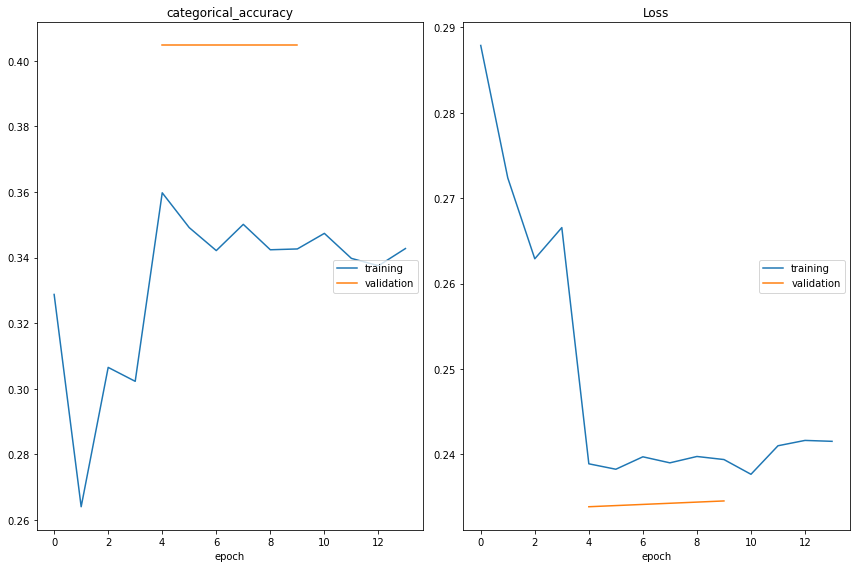

categorical_accuracy
	training         	 (min:    0.264, max:    0.360, cur:    0.343)
	validation       	 (min:    0.405, max:    0.405, cur:    0.405)
Loss
	training         	 (min:    0.238, max:    0.288, cur:    0.242)
	validation       	 (min:    0.234, max:    0.235, cur:    0.235)
250/250 [==============================] - 129s 516ms/step - batch: 124.5000 - size: 32.0000 - loss: 0.2415 - categorical_accuracy: 0.3428
Epoch 15/100
250/250 [==============================] - ETA: 0s - batch: 124.5000 - size: 32.0000 - loss: 0.2397 - categorical_accuracy: 0.3408

KeyboardInterrupt: 

In [2]:
pipeline = MyAutoencoder(
                         data_train_autoencoder='data/Feit_colon-annotation-tiles-128/data_train/',
                         data_valid_autoencoder='data/Feit_colon-annotation-tiles-128/data_valid/',
                         data_train_neighborhood='data/Feit_colon-annotation-tiles-128-2-neighbourhood/data_train',
                         data_valid_neighborhood='data/Feit_colon-annotation-tiles-128-2-neighbourhood/data_valid',
                          train_data_dir='data/Feit_colon-annotation-tiles-128/data_train/',
                         valid_data_dir='data/Feit_colon-annotation-tiles-128/data_valid/')

pipeline.execute_pipeline(perform_validation=False, perform_test_segmentation=False)


In [ ]:
from ml.eval import eval_model

eval_model(pipeline.model,
           pipeline.get_data_loader_validation_neighborhood(),
           pipeline_name=name,
           print_confusion_matrix=True,
           save_misclassified=True)

In [ ]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1)